In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.model_selection import train_test_split
import time
import re
import os

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras import layers, models, regularizers

# Data loading

In [ ]:
df = pd.read_csv('final_data.csv')

# Preprocessing

In [ ]:
df.head()

,filename,grade,matrix,benchmark,stars
0,boulder_62660.png,Grade: User 6B+/V4/ Setter 6B+/V4,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,3
1,boulder_34426.png,Grade: User 6C/V5/ Setter 6C/V5,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
2,boulder_24635.png,Grade: User 6C+/V5/ Setter 6C+/V5,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
3,boulder_74002.png,6C+/V5,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
4,boulder_33349.png,Grade: User 6B+/V4/ Setter 6B+/V4,"[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77442 entries, 0 to 77441
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   77442 non-null  object
 1   grade      77442 non-null  object
 2   matrix     77442 non-null  object
 3   benchmark  77442 non-null  bool  
 4   stars      77442 non-null  int64 
dtypes: bool(1), int64(1), object(3)
memory usage: 2.4+ MB


## Stars

Only routes that received three or more stars were included. The underlying hypothesis is that routes with two or fewer stars may be less reliable in terms of their assigned grade, possibly due to lower community agreement or inconsistencies in setting quality. By focusing on higher-rated routes, the overall consistency and trustworthiness of the dataset is expected to improve.

In [ ]:
total_routes = len(df)
low_star_count = (df['stars'] < 3).sum()

print(f"📊 Total routes: {total_routes}")
print(f"❌ Routes with 3 stars or fewer: {low_star_count}")
print(f"✅ Routes with more than 3 stars: {total_routes - low_star_count}")

📊 Total routes: 77442
❌ Routes with 3 stars or fewer: 6897
✅ Routes with more than 3 stars: 70545


In [ ]:
df = df[df['stars'] >= 3]

## Grade

The grade column must be standardized to ensure consistency in the format of the target variable. This process involves converting all grade labels into a uniform representation, which is essential for reliable model training and evaluation.

### Standarization

In [ ]:
df['grade'] = df['grade'].str.replace('Grade: User ', '', regex=False)
df['grade'] = df['grade'].str.replace(r' Setter.*', '', regex=True)
df['grade'] = df['grade'].str.strip()

In [ ]:
#Checking changes
df.head()

,filename,grade,matrix,benchmark,stars
0,boulder_62660.png,6B+/V4/,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,3
1,boulder_34426.png,6C/V5/,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
2,boulder_24635.png,6C+/V5/,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
3,boulder_74002.png,6C+/V5,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
4,boulder_33349.png,6B+/V4/,"[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4


Keeping just font scale, deleting V scale.

In [ ]:
df['grade'] = df['grade'].str.replace(r'/.*', '', regex=True)
df.head()

,filename,grade,matrix,benchmark,stars
0,boulder_62660.png,6B+,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,3
1,boulder_34426.png,6C,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
2,boulder_24635.png,6C+,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
3,boulder_74002.png,6C+,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
4,boulder_33349.png,6B+,"[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4


In [ ]:
sorted(df['grade'].unique())

['6B',
 '6B+',
 '6Bt',
 '6C',
 '6C+',
 '7A',
 '7A+',
 '7AIV6',
 '7At',
 '7B',
 '7B+',
 '7C',
 '7C+',
 '7TAIN6',
 '7TAIV6',
 '8A',
 '8A+',
 '8B',
 '8B+',
 'JA+',
 'S > & & & ¢',
 'S a ao & aXe',
 'S a ao aXkaXd',
 'TA',
 'TA+',
 'TA+IVT',
 'TAIN',
 'TAIN6',
 'TAIV6',
 'TAT',
 'TAt',
 'TAt+',
 'ee eS eed',
 'unknown',
 'vevarertare']

Some irregular grade formats were identified, likely resulting from incorrect OCR processing. The frequency of each format will be examined to assess whether they can be individually reviewed in conjunction with their corresponding images.

In [ ]:
# Regular expression for valid Fontainebleau-style grades (e.g., 6A, 7B+, 8C)
valid_grade_pattern = r'^[4-9][A-Ca-c]\+?$'

# Applying the pattern to the 'grade' column
is_valid = df['grade'].str.match(valid_grade_pattern, na=False)

valid_count = is_valid.sum()
invalid_count = (~is_valid).sum()

print(f"✅ Valid format: {valid_count}")
print(f"❌ Invalid format: {invalid_count}")

# Filter and count the invalid grade formats
invalid_grades_df = df[~is_valid]
invalid_grade_counts = invalid_grades_df['grade'].value_counts().reset_index()
invalid_grade_counts.columns = ['grade', 'count']
invalid_grade_counts

✅ Valid format: 64951
❌ Invalid format: 5594


,grade,count
0,TAt,1355
1,S > & & & ¢,1171
2,TAIV6,1170
3,S a ao & aXe,1142
4,TA+,290
5,S a ao aXkaXd,133
6,6Bt,130
7,7TAIV6,87
8,7AIV6,39
9,TA,29


- A semi-manual and somewhat handcrafted approach will be adopted to standardize the grade format. The most frequent invalid grade formats will be manually reviewed and corrected, as they account for the majority of inconsistencies.

- To support this process, a set of random samples will be selected for each invalid format, and their corresponding route images will be visually inspected to infer the intended grade based on clear visual evidence. Less common or ambiguous formats—particularly those without consistent visual patterns—will be discarded to preserve data quality and minimize noise.

#### Format TAt and TA+

In [ ]:
df[df['grade'] == 'TAt']

,filename,grade,matrix,benchmark,stars
14,boulder_11856.png,TAt,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
186,boulder_44843.png,TAt,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
231,boulder_37661.png,TAt,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
232,boulder_16877.png,TAt,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,5
282,boulder_00973.png,TAt,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, ...",False,5
...,...,...,...,...,...
77141,boulder_30842.png,TAt,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
77216,boulder_41936.png,TAt,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, ...",False,4
77395,boulder_09966.png,TAt,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
77423,boulder_10589.png,TAt,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, ...",False,5


In [ ]:
df[df['grade'] == 'TA+']

,filename,grade,matrix,benchmark,stars
39,boulder_31238.png,TA+,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
469,boulder_30867.png,TA+,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
634,boulder_01847.png,TA+,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, ...",False,5
645,boulder_31984.png,TA+,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, ...",False,4
679,boulder_11498.png,TA+,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, ...",False,5
...,...,...,...,...,...
75065,boulder_60696.png,TA+,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, ...",False,3
75600,boulder_32884.png,TA+,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
75673,boulder_14314.png,TA+,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,5
76350,boulder_16305.png,TA+,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5


After 10 sample images labeled with the grades TAt and TA+ were reviewed, all were found to visually correspond to grade 7A+. This observation aligns with the OCR output, which incorrectly labeled them as TAt or TA+. Consequently, all instances of TAt will be replaced with 7A+.

In [ ]:
df['grade'] = df['grade'].replace('TAt', '7A+')
df['grade'] = df['grade'].replace('TA+', '7A+')

#### Format TAIV6

In [ ]:
df[df['grade'] == 'TAIV6']

,filename,grade,matrix,benchmark,stars
68,boulder_13927.png,TAIV6,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
148,boulder_41085.png,TAIV6,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
258,boulder_35076.png,TAIV6,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
304,boulder_11895.png,TAIV6,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
315,boulder_42573.png,TAIV6,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
...,...,...,...,...,...
77233,boulder_36572.png,TAIV6,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, ...",False,4
77286,boulder_39127.png,TAIV6,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
77366,boulder_75477.png,TAIV6,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, ...",False,4
77385,boulder_59189.png,TAIV6,"[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, ...",False,3


After 10 sample images labeled with the grade *TAIV6* were reviewed, all were found to visually correspond to *7A/V6*. This finding is consistent with the OCR output, which mistakenly labeled them as *TAIV6*. Therefore, all instances of *TAIV6* will be replaced with *7A*.

In [ ]:
df['grade'] = df['grade'].replace('TAIV6', '7A')

#### Format S > & & & ¢

In [ ]:
df[df['grade'] == 'S > & & & ¢']

,filename,grade,matrix,benchmark,stars
25,boulder_10590.png,S > & & & ¢,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
187,boulder_02816.png,S > & & & ¢,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, ...",False,5
208,boulder_18696.png,S > & & & ¢,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, ...",False,5
293,boulder_19211.png,S > & & & ¢,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, ...",False,5
322,boulder_12344.png,S > & & & ¢,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
...,...,...,...,...,...
76954,boulder_10210.png,S > & & & ¢,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
76962,boulder_00765.png,S > & & & ¢,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, ...",False,5
77193,boulder_13916.png,S > & & & ¢,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
77427,boulder_13080.png,S > & & & ¢,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5


The grade "S > & & & ¢" does not follow any recognizable pattern, and the associated routes span various difficulty levels. To prevent the introduction of noisy or inaccurate data, all records with this grade will be removed.

In [ ]:
df = df[df['grade'] != 'S > & & & ¢']

#### Format S a ao & aXe

In [ ]:
df[df['grade'] == 'S a ao & aXe']

,filename,grade,matrix,benchmark,stars
89,boulder_36543.png,S a ao & aXe,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
150,boulder_28033.png,S a ao & aXe,"[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 0, 0, ...",False,4
162,boulder_73751.png,S a ao & aXe,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
245,boulder_34368.png,S a ao & aXe,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
426,boulder_30697.png,S a ao & aXe,"[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
...,...,...,...,...,...
77045,boulder_35090.png,S a ao & aXe,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
77117,boulder_33393.png,S a ao & aXe,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
77171,boulder_34417.png,S a ao & aXe,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
77260,boulder_34365.png,S a ao & aXe,"[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4


The grade format "S a ao & aXe" fluctuates between 6C/V5 and 7A/V6. However, as it does not correspond to a single grading system and introduces ambiguity, these entries will be removed to avoid the inclusion of incorrect labels.

In [ ]:
df = df[df['grade'] != 'S a ao & aXe']

#### Format 6Bt

In [ ]:
df[df['grade'] == '6Bt']

,filename,grade,matrix,benchmark,stars
631,boulder_60275.png,6Bt,"[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,3
3197,boulder_10142.png,6Bt,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
3267,boulder_60328.png,6Bt,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,3
3652,boulder_13265.png,6Bt,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,5
3893,boulder_12812.png,6Bt,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,5
...,...,...,...,...,...
75582,boulder_33556.png,6Bt,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
75591,boulder_73172.png,6Bt,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
76011,boulder_74345.png,6Bt,"[[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], [0, 0, 0, ...",False,4
76097,boulder_38629.png,6Bt,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4


After 10 sample images labeled with the grade 6Bt were reviewed, all were found to visually correspond to 7A+. This observation aligns with the OCR output, which mistakenly labeled them as 6Bt. Therefore, all instances of 6Bt will be replaced with 7A+.

In [ ]:
df['grade'] = df['grade'].replace('6Bt', '6B+')

### Final grades

In [ ]:
is_valid = df['grade'].str.match(valid_grade_pattern, na=False)

valid_count = is_valid.sum()
invalid_count = (~is_valid).sum()

print(f"✅ Valid format: {valid_count}")
print(f"❌ Invalid format: {invalid_count}")

invalid_grades_df = df[~is_valid]
invalid_grade_counts = invalid_grades_df['grade'].value_counts().reset_index()
invalid_grade_counts.columns = ['grade', 'count']
invalid_grade_counts

✅ Valid format: 67896
❌ Invalid format: 336


,grade,count
0,S a ao aXkaXd,133
1,7TAIV6,87
2,7AIV6,39
3,TA,29
4,TAt+,14
5,TAIN6,10
6,TAIN,8
7,JA+,5
8,7TAIN6,4
9,unknown,2


The remaining invalid grade formats will be removed, as they represent only 336 entries out of a total of 67,896 valid records—approximately 0.49% of the dataset. Their exclusion helps preserve data quality while having a negligible impact on the overall dataset size.

In [ ]:
df = df[is_valid].reset_index(drop=True)

In [ ]:
#Checking results
sorted(df['grade'].unique())

['6B',
 '6B+',
 '6C',
 '6C+',
 '7A',
 '7A+',
 '7B',
 '7B+',
 '7C',
 '7C+',
 '8A',
 '8A+',
 '8B',
 '8B+']

/tmp/ipython-input-28-3471796454.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


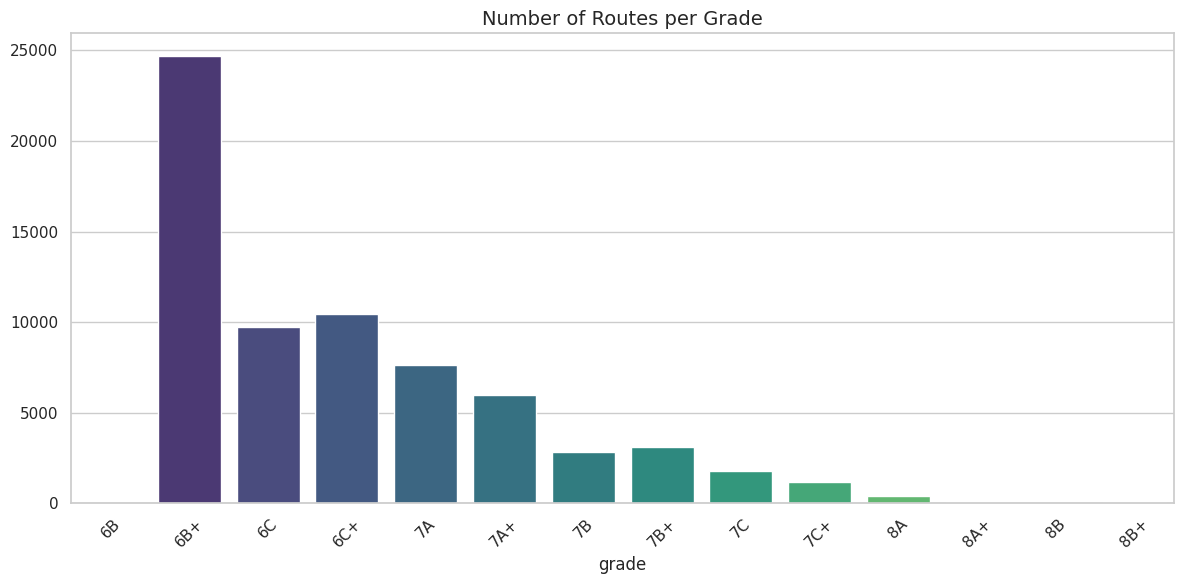

In [ ]:
# Number of routes per grade and sort by grade
grade_counts = df['grade'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# bar plot
sns.barplot(
    x=grade_counts.index,
    y=grade_counts.values,
    palette="viridis"
)

# title and axis labels
plt.title("Number of Routes per Grade", fontsize=14)
plt.xticks(
    rotation=45
)
plt.tight_layout()
plt.show()

1. Clear bias toward intermediate grades (6B+, 6C+):

 - The majority of the routes are concentrated in grades like 6B+, 6C+, and 6C, suggesting that both users and setters tend to create or rate problems in the lower-intermediate range.

 - This likely reflects the general skill level of MoonBoard users, as most climbers may fall within this range.

2. Long tail toward higher difficulty:

 - There's a gradual drop in route count as difficulty increases, especially beyond 7B+.

 - This results in a class imbalance that could affect model training — higher grades have far fewer samples

3. Implications for model training:

  - The model may be biased toward the most frequent grades.

  - This makes traditional accuracy potentially misleading.

In [ ]:
df[df['grade'] == '6B']

,filename,grade,matrix,benchmark,stars
52491,boulder_09194.png,6B,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,5
56455,boulder_74381.png,6B,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4


The grade class 6B will be removed, as it is represented by only 2 records in the dataset. Its exclusion is intended to prevent instability during model training due to insufficient representation.

In [ ]:
df = df[df['grade'] != '6B']

The extreme grades (8A, 8A+, 8B, and 8B+) will also be removed from the dataset due to their very low frequency. These grades are significantly underrepresented, which could lead to poor generalization and model instability. By focusing on more populated and reliable grades (6B+ to 7C+), a more robust and balanced model is expected to be achieved.

In [ ]:
valid_grades = ['6B+', '6C', '6C+', '7A', '7A+', '7B', '7B+', '7C', '7C+']
df = df[df['grade'].isin(valid_grades)].copy()

# Validating
df['grade'].unique()

array(['6B+', '6C', '6C+', '7A+', '7A', '7B+', '7B', '7C', '7C+'],
      dtype=object)

## Transformation

To train the model, each climbing grade (e.g., 6C+, 7A) is mapped to an integer reflecting its difficulty level. This ordinal encoding preserves the natural order of grades, allowing the model to learn their progression. Rather than treating the task as a multiclass classification problem, an ordinal regression approach is employed to account for the fact that misclassifying a 7A as 6C is less severe than misclassifying it as 8B+.

In [ ]:
# Mapping dicts
grade_to_int = {grade: idx for idx, grade in enumerate(valid_grades)}
int_to_grade = {idx: grade for grade, idx in grade_to_int.items()}

df['grade'] = df['grade'].map(grade_to_int)

#Checking results
df.head()

,filename,grade,matrix,benchmark,stars
0,boulder_62660.png,0,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,3
1,boulder_34426.png,1,"[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,4
2,boulder_24635.png,2,"[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ...",False,5
3,boulder_74002.png,2,"[[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4
4,boulder_33349.png,0,"[[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, ...",False,4


## Benchmark

In [ ]:
print(f"✅ Benchmarked routes: {(df['benchmark']).sum()}")

✅ Benchmarked routes: 508


The distribution of the target variable (grade) is examined separately for benchmark and non-benchmark routes.

/tmp/ipython-input-35-242011706.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


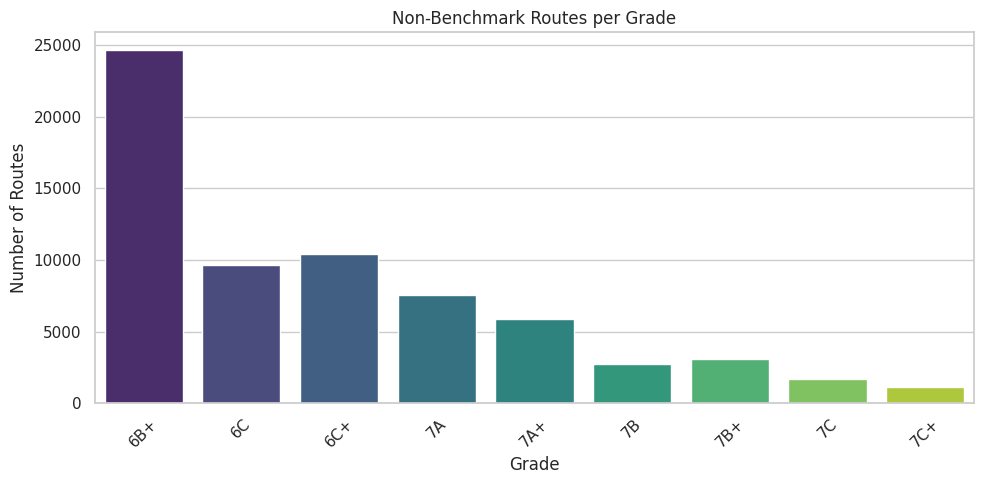

/tmp/ipython-input-35-242011706.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


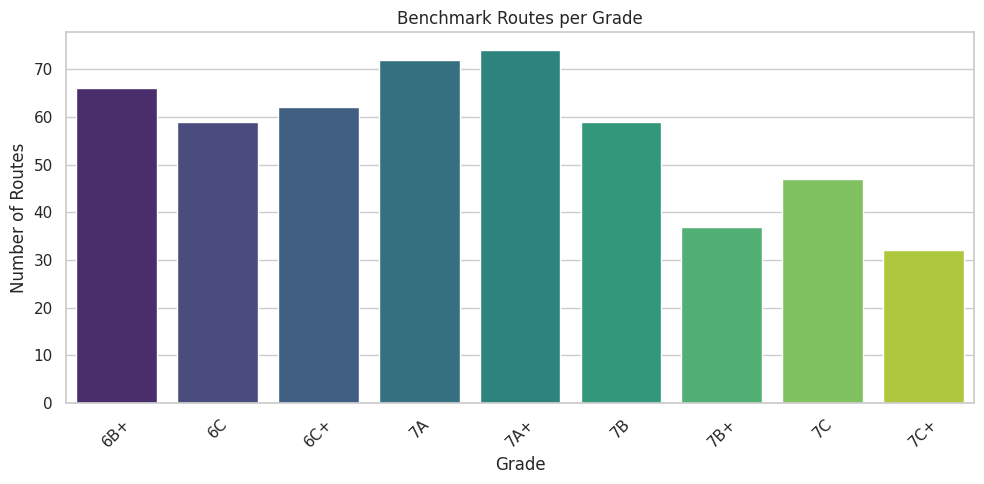

In [ ]:
# Benchmark and non-benchmark routes
is_benchmark = df['benchmark'].fillna(False).astype(bool)
is_non_benchmark = ~is_benchmark

df_benchmark = df[is_benchmark]
df_non_benchmark = df[is_non_benchmark]

# Grades for both sets
benchmark_counts = df_benchmark['grade'].value_counts().sort_index()
non_benchmark_counts = df_non_benchmark['grade'].value_counts().sort_index()

# Non-Benchmark Routes
plt.figure(figsize=(10, 5))
sns.barplot(
    x=list(non_benchmark_counts.index),
    y=non_benchmark_counts.values,
    palette='viridis'
)
plt.title('Non-Benchmark Routes per Grade')
plt.xlabel('Grade')
plt.ylabel('Number of Routes')
plt.xticks(
    ticks=range(len(non_benchmark_counts)),
    labels=[int_to_grade[i] for i in non_benchmark_counts.index],
    rotation=45
)
plt.tight_layout()
plt.show()

# Benchmark Routes
plt.figure(figsize=(10, 5))
sns.barplot(
    x=list(benchmark_counts.index),
    y=benchmark_counts.values,
    palette='viridis'
)
plt.title('Benchmark Routes per Grade')
plt.xlabel('Grade')
plt.ylabel('Number of Routes')
plt.xticks(
    ticks=range(len(benchmark_counts)),
    labels=[int_to_grade[i] for i in benchmark_counts.index],
    rotation=45
)
plt.tight_layout()
plt.show()

1. **Non-Benchmark Routes:**

  - These are by far the most abundant, with a strong skew toward moderate grades.

  - The most common grade is 6B+, followed by 6C+, 6C, and 7A.

  - The distribution shows a steep drop-off as difficulty increases beyond 7A+, with very few problems in grades above 7C.

  - This skew is expected since most MoonBoard users tend to climb within moderate difficulty levels.

2. **Benchmark Routes:**

  - These are much fewer in number overall (note the difference in y-axis scale).

  - The distribution is more balanced, with a peak around 7A and 7A+.

  - Unlike the non-benchmark set, benchmark problems are more evenly spread between 6B+ and 7C+, indicating a deliberate effort to maintain benchmark quality across a broader grade spectrum.

  - Even at higher grades (e.g., 7C+), there is still benchmark representation, suggesting these problems are carefully selected and validated.



# First Approach: Spatial relationships

Two baseline architectures proposed by Petashvili et al. (2023) were adopted: a CNN and an LSTM. These models demonstrated the best performance in their experiments on MoonBoard grade prediction.

## Splitting the data

To ensure a reliable and consistent evaluation of model performance, **benchmark** problems are used as the test set. Benchmark problems on MoonBoard are carefully selected by the community and are generally considered to represent well-graded, high-quality climbs. Since these problems are less susceptible to setter bias or user grading errors, they serve as a more objective reference for model evaluation.

In [ ]:
#Casting matrix column to numpy
df['matrix'] = df['matrix'].apply(lambda x: np.array(ast.literal_eval(x)))

# Filter Benchmarks as test group
df_test = df[df['benchmark'] == True]
df_train = df[df['benchmark'] == False]

# prepare variables for the split
X_train = np.stack(df_train['matrix'].to_numpy())
y_train = df_train['grade'].to_numpy()

# Test data (benchmarks)
X_test = np.stack(df_test['matrix'].to_numpy())
y_test = df_test['grade'].to_numpy()

In [ ]:
X_train.shape

(66810, 18, 11)

In [ ]:
X_test.shape

(508, 18, 11)

The target variable (climbing grade) will be normalized to the [0, 1] range to improve training stability and convergence. Since neural networks tend to perform better when input and output values are on similar scales, mapping the grades—originally represented as integers from 0 to 8—facilitates more effective learning. After prediction, the scaling can be reversed to recover the original grade values.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).flatten()

## Training

In [ ]:
# Expand channel dimension (from 18x11 to 18x11x1)
X_train_nn = np.expand_dims(X_train, axis=-1)
X_test_nn = np.expand_dims(X_test, axis=-1)

cnn = models.Sequential( [
    layers.Input( shape = ( 18, 11, 1 ) ),
    layers.Conv2D( 32, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 32, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Conv2D( 64, 3, activation = 'relu' ),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense( 32, activation = 'relu' ),
    layers.Dense( 1, activation = 'linear' ),
] )

lstm = models.Sequential( [
    layers.Input( shape = ( 18, 11, 1 ) ),
    layers.Reshape( target_shape = ( 18, 11 ) ),
    layers.LSTM( 128 ),
    layers.Dense( 32, activation = 'relu' ),
    layers.Dense( 1, activation = 'linear' ),
] )

In [ ]:
models = [ cnn, lstm ]

for model in models:
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = [
            tf.keras.metrics.RootMeanSquaredError( name = 'RMSE' ),
            tf.keras.metrics.MeanAbsoluteError( name = 'MAE' ),
        ]
    )

### Convolutional Neural network

In [ ]:
print("\nTraining model: 2DCNN")
start_time = time.time()

history = cnn.fit(
    X_train_nn,
    y_train_scaled,
    validation_data=(X_test_nn, y_test_scaled),
    epochs=200,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=20,
            restore_best_weights=True,
            start_from_epoch=10,
        )
    ],
    verbose=1
)

# Training time
fit_time_cnn = time.time() - start_time
print(f"🕒 Time to Fit 2DCNN: {fit_time_cnn:.2f} seconds")


Training model: 2DCNN
Epoch 1/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - MAE: 0.1820 - RMSE: 0.2778 - loss: 0.0897 - val_MAE: 0.1324 - val_RMSE: 0.1664 - val_loss: 0.0277
Epoch 2/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - MAE: 0.1255 - RMSE: 0.1674 - loss: 0.0280 - val_MAE: 0.1537 - val_RMSE: 0.1907 - val_loss: 0.0363
Epoch 3/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - MAE: 0.1199 - RMSE: 0.1598 - loss: 0.0255 - val_MAE: 0.1216 - val_RMSE: 0.1548 - val_loss: 0.0240
Epoch 4/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - MAE: 0.1161 - RMSE: 0.1548 - loss: 0.0240 - val_MAE: 0.1433 - val_RMSE: 0.1802 - val_loss: 0.0325
Epoch 5/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - MAE: 0.1119 - RMSE: 0.1501 - loss: 0.0225 - val_MAE: 0.1182 - val_RMSE: 0.1477 - val_loss: 0.0218
Epoch 6/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - MAE: 0.1108 - RMSE: 0.1481 - loss: 0.0219 - val_MAE: 0.1239 - val_RMSE: 0.1558 - val_loss: 0.0243
Epoch 7/200
8352/8352 ━━━━━━━━━━━━━━━━━━━

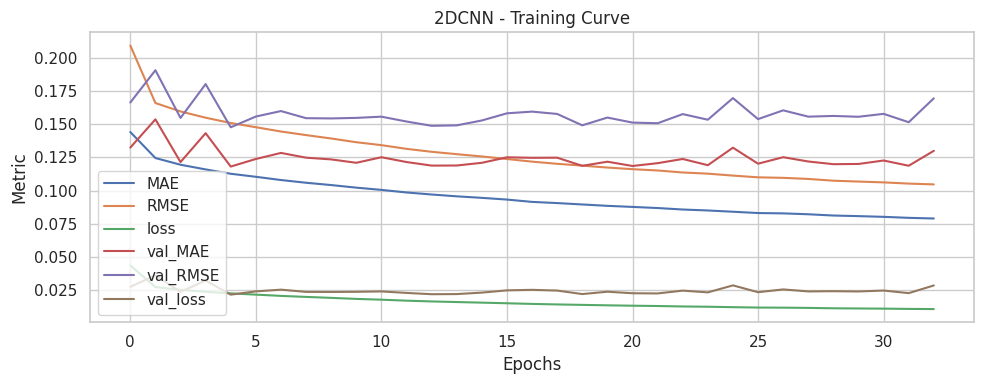

In [ ]:
# Training curves
plt.figure(figsize=(10, 4))
for key in history.history.keys():
    plt.plot(history.history[key], label=key)
plt.title('2DCNN - Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

A clear convergence trend is observed in the training metrics (MAE, RMSE, loss), indicating that the model is learning effectively. On the validation set, the metrics (val_MAE, val_RMSE, val_loss) improve during the initial epochs and reach their minimum around epochs 15–20. However, they start to fluctuate afterwards, suggesting the onset of **overfitting**.

### LSTM (Long Short Term Memory)

In [ ]:
print("\nTraining model: LSTM")
start_time = time.time()

history = lstm.fit(
    X_train_nn,
    y_train_scaled,
    validation_data=(X_test_nn, y_test_scaled),
    epochs=200,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=20,
            restore_best_weights=True,
            start_from_epoch=10,
        )
    ],
    verbose=1
)

# Training time
fit_time_lstm = time.time() - start_time
print(f"🕒 Time to Fit LSTM: {fit_time_lstm:.2f} seconds")


Training model: LSTM
Epoch 1/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - MAE: 0.1574 - RMSE: 0.2079 - loss: 0.0435 - val_MAE: 0.1983 - val_RMSE: 0.2480 - val_loss: 0.0615
Epoch 2/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - MAE: 0.1348 - RMSE: 0.1807 - loss: 0.0326 - val_MAE: 0.1470 - val_RMSE: 0.1886 - val_loss: 0.0356
Epoch 3/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - MAE: 0.1264 - RMSE: 0.1709 - loss: 0.0292 - val_MAE: 0.1490 - val_RMSE: 0.1887 - val_loss: 0.0356
Epoch 4/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - MAE: 0.1200 - RMSE: 0.1626 - loss: 0.0265 - val_MAE: 0.1388 - val_RMSE: 0.1749 - val_loss: 0.0306
Epoch 5/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - MAE: 0.1158 - RMSE: 0.1569 - loss: 0.0246 - val_MAE: 0.1340 - val_RMSE: 0.1695 - val_loss: 0.0287
Epoch 6/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - MAE: 0.1129 - RMSE: 0.1533 - loss: 0.0235 - val_MAE: 0.1191 - val_RMSE: 0.1512 - val_loss: 0.0229
Epoch 7/200
8352/8352 ━━━━━━━━━━━━━━━━━━━━

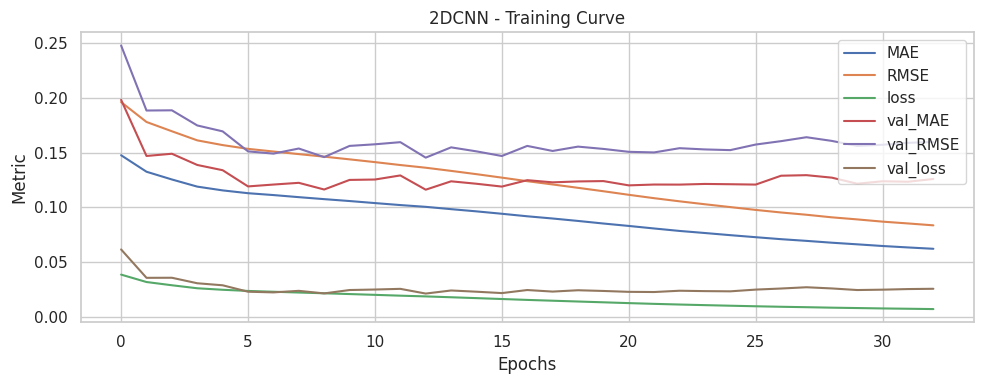

In [ ]:
# Training curves
plt.figure(figsize=(10, 4))
for key in history.history.keys():
    plt.plot(history.history[key], label=key)
plt.title('2DCNN - Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This training curve demonstrates a sharper divergence between training and validation metrics, especially after epoch 10. This version of the model shows stronger overfitting than the previous one. While early performance is promising, training beyond 10–15 epochs does not yield validation improvement. Regularization and better stopping criteria could enhance generalization performance.


## Evaluation

To assess model performance, standard regression metrics — Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) — are used. These metrics are chosen because they provide complementary insights:

- **MAE** measures the average magnitude of the prediction errors, regardless of direction.
- **RMSE** penalizes larger errors more heavily, making it sensitive to outliers.

Both training and test set metrics are reported to evaluate generalization performance and to detect potential overfitting. Additionally, training time (fit time) is recorded as a proxy for model efficiency.

Formally, the metrics are defined as:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| \hat{y}_i - y_i \right|, \quad
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} \left( \hat{y}_i - y_i \right)^2 }
$$

where $\hat{y}_i$ is the predicted grade (as a scalar ordinal value) and $y_i$ is the ground truth.

In [ ]:
#2DCNN
pred_scaled_cnn = cnn.predict(X_test_nn)
pred_cnn = scaler.inverse_transform(pred_scaled_cnn).flatten()

mae_value_cnn = mae(y_test, pred_cnn)
rmse_value_cnn = mse(y_test, pred_cnn)

#LSTM
pred_scaled_lstm = lstm.predict(X_test_nn)
pred_lstm = scaler.inverse_transform(pred_scaled_lstm).flatten()

mae_value_lstm = mae(y_test, pred_lstm)
rmse_value_lstm = mse(y_test, pred_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
print("Convolusional neural network")
print(f"CNN Test MAE: {mae_value_cnn:.3f}")
print(f"CNN Test RMSE: {rmse_value_cnn:.3f}")
print("---")

print("Long Short Term Memory")
print(f"LSTM Test MAE: {mae_value_lstm:.3f}")
print(f"LSTM Test RMSE: {rmse_value_lstm:.3f}")

Convolusional neural network
CNN Test MAE: 0.951
CNN Test RMSE: 1.418
---
Long Short Term Memory
LSTM Test MAE: 0.929
LSTM Test RMSE: 1.354


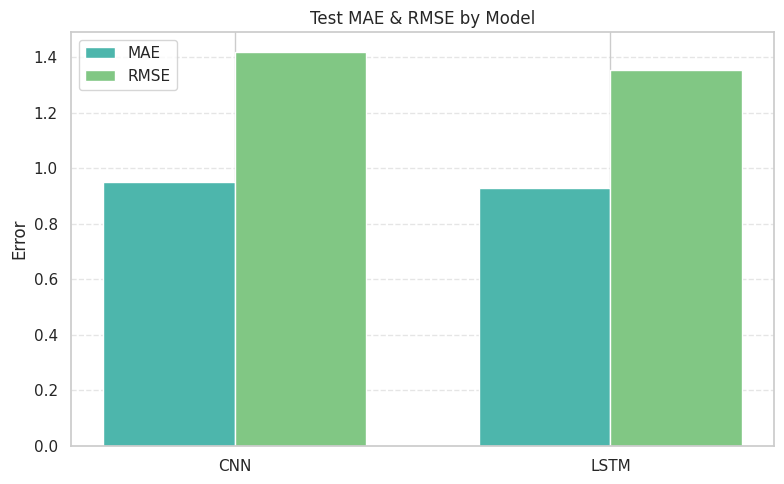

In [ ]:
# Metrics
models = ['CNN', 'LSTM']
mae_scores = [mae_value_cnn, mae_value_lstm]
rmse_scores = [rmse_value_cnn, rmse_value_lstm]

x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 5))

mae_color = '#4DB6AC'
rmse_color = '#81C784'

# Bars
plt.bar([i - width/2 for i in x], mae_scores, width=width, label='MAE', color=mae_color)
plt.bar([i + width/2 for i in x], rmse_scores, width=width, label='RMSE', color=rmse_color)

plt.xticks(x, models)
plt.ylabel("Error")
plt.title("Test MAE & RMSE by Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Both models demonstrate comparable performance on the test set. However, the LSTM slightly outperforms the CNN in both MAE and RMSE metrics:

- Lower MAE indicates that the LSTM makes smaller average errors.

- Lower RMSE suggests it is also more robust to larger errors.

These results imply that the LSTM may be better at capturing sequential or spatial relationships in the hold matrix, which could be beneficial for modeling climbing route difficulty. While the difference is modest, the LSTM shows a consistent edge across evaluation metrics.

# Embeddings

To capture the intrinsic properties that influence the difficulty of using a climbing hold, visual embeddings were incorporated into the model. Images of individual holds were processed to generate vector representations in a latent space, where semantic and morphological characteristics—such as size, shape, texture, and orientation—were preserved. These embeddings were used as enriched input features, enabling the model to learn more effectively from the visual complexity of each hold.

A mapping (hold_to_idx) will be created from each hold ID (e.g., "A5") to its corresponding index in the array of embeddings. This mapping will be used to identify which embedding corresponds to each hold.

In [ ]:
from PIL import Image

# Images route
folder = "holds/"

# Load valid images
valid_extensions = (".jpg", ".png", ".jpeg")
file_names = sorted([
    f for f in os.listdir(folder) if f.lower().endswith(valid_extensions)
])

images = []
hold_to_idx = {}

for i, file_name in enumerate(file_names):
    route = os.path.join(folder, file_name)
    img = Image.open(route).convert("RGB").resize((128, 128))
    img_array = np.array(img) / 255.0

    images.append(img_array)

    # Deleting the extension from the name
    hold_id = os.path.splitext(file_name)[0].upper()  # ej: "A5"
    hold_to_idx[hold_id] = i  # ej: "A5" - 17

holds_array = np.array(images)  # shape: (198, 128, 128, 3)
print(hold_to_idx)

{'A10': 0, 'A11': 1, 'A12': 2, 'A13': 3, 'A14': 4, 'A15': 5, 'A16': 6, 'A18': 7, 'A5': 8, 'A9': 9, 'B10': 10, 'B11': 11, 'B12': 12, 'B13': 13, 'B15': 14, 'B16': 15, 'B18': 16, 'B3': 17, 'B4': 18, 'B6': 19, 'B7': 20, 'B8': 21, 'B9': 22, 'C10': 23, 'C11': 24, 'C12': 25, 'C13': 26, 'C14': 27, 'C15': 28, 'C16': 29, 'C18': 30, 'C5': 31, 'C6': 32, 'C7': 33, 'C8': 34, 'C9': 35, 'D10': 36, 'D11': 37, 'D12': 38, 'D13': 39, 'D14': 40, 'D15': 41, 'D16': 42, 'D17': 43, 'D18': 44, 'D3': 45, 'D5': 46, 'D6': 47, 'D7': 48, 'D8': 49, 'D9': 50, 'E10': 51, 'E11': 52, 'E12': 53, 'E13': 54, 'E14': 55, 'E15': 56, 'E16': 57, 'E18': 58, 'E6': 59, 'E7': 60, 'E8': 61, 'E9': 62, 'F10': 63, 'F11': 64, 'F12': 65, 'F13': 66, 'F14': 67, 'F15': 68, 'F16': 69, 'F5': 70, 'F6': 71, 'F7': 72, 'F8': 73, 'F9': 74, 'G10': 75, 'G11': 76, 'G12': 77, 'G13': 78, 'G14': 79, 'G15': 80, 'G16': 81, 'G17': 82, 'G18': 83, 'G2': 84, 'G4': 85, 'G6': 86, 'G7': 87, 'G8': 88, 'G9': 89, 'H10': 90, 'H11': 91, 'H12': 92, 'H13': 93, 'H14': 94

As a first step, a convolutional autoencoder is trained to map hold images into a low-dimensional latent space and reconstruct them from this representation. The encoder compresses each image into a compact embedding, while the decoder attempts to reconstruct the original image from it.

In [ ]:
# parameters
input_shape = (128, 128, 3)
embedding_dim = 32

# Encoder
inputs = layers.Input(shape=input_shape)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D()(x)  # 64x64
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)  # 32x32
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)  # 16x16
x = layers.Flatten()(x)
embedding = layers.Dense(embedding_dim, name="embedding")(x)

# Decoder
x = layers.Dense(16 * 16 * 128, activation='relu')(embedding)
x = layers.Reshape((16, 16, 128))(x)
x = layers.UpSampling2D()(x)  # 32x32
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)  # 64x64
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)  # 128x128
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder
autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 32)             │     1,048,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32768)          │     1,081,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 128, 128, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,316,323 (8.84 MB)

 Trainable params: 2,316,323 (8.84 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(
    x=holds_array,
    y=holds_array, # autoencoder: input is the same as output
    batch_size=32,
    epochs=50,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 757ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0118 - val_loss: 0.0104
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0113 - val_loss: 0.0098
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0120 - val_loss: 0.0097
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0113 - val_loss: 0.0093
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0112 - val_loss: 0.0095
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0102 - val_loss: 0.0086
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0095 - val_loss: 0.0076
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0089 - val_loss: 0.0073


- Once the model is trained, the decoder is discarded and only the encoder is retained to extract embeddings.

- Each hold image is then processed through the trained encoder to generate its corresponding embedding vector.

In [ ]:
from tensorflow.keras import Model

embedding_model = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("embedding").output
)

In [ ]:
embeddings = embedding_model.predict(holds_array)  # shape: (198, 32)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


In [ ]:
#This method helps to map from an index of the 18x11 matrix to the name of the hold

def idx_to_hold(i, j):
    letter = chr(65 + j)   # A-K
    number = 18 - i       # row 0 is 18
    return f"{letter}{number}"

## Embedding visualization

To assess whether the learned embeddings meaningfully capture the visual properties of each hold, a two-dimensional projection of the embedding space is generated. This visualization allows us to analyze the spatial arrangement of holds based on their learned features and to explore whether visually similar holds are placed near each other in the latent space.

Only the MoonBoard indices corresponding to actual holds are retained. Since not every position on the 18×11 grid contains a hold, filtering is applied to exclude empty or unused locations.

In [ ]:
idx_to_hold = {v: k for k, v in hold_to_idx.items()}  # {0: "A1", 1: "A2", ...}

valid_idx = sorted(idx_to_hold.keys())  # All indexes
if len(valid_idx) > embeddings.shape[0]:
    valid_idx = valid_idx[:embeddings.shape[0]]  # out of range

# Filtered dict
idx_to_hold = {i: idx_to_hold[i] for i in valid_idx}

To visualize the structure of the embedding space, **t-distributed Stochastic Neighbor Embedding (t-SNE)** is applied to reduce the 32-dimensional hold embeddings to 2 dimensions. This nonlinear technique is well-suited for capturing local relationships in high-dimensional data and projecting them into a space that can be visually interpreted.

In this case, t-SNE is configured with the following parameters:
- **n_components=2**: to obtain a 2D representation,
- **perplexity=15**: which balances local and global structure,
- **learning_rate=200**: for stable convergence,
- **random_state=42**: to ensure reproducibility.

**t-SNE** is chosen because of its effectiveness in preserving local neighborhood structures, allowing similar holds to remain close together in the projected space. As the embeddings were produced by a non-linear autoencoder, it was expected that the relationships between holds would be inherently non-linear as well.

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=15, learning_rate=200, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)  # (198, 2)

Now that the 2D representations of the embeddings have been obtained, KMeans clustering will be applied to explore whether the holds can be meaningfully grouped based on their visual features.

To determine the appropriate number of clusters, the **elbow method** will be used. This technique involves computing the clustering error (inertia) for a range of cluster counts and identifying the point where adding more clusters yields diminishing returns in error reduction.

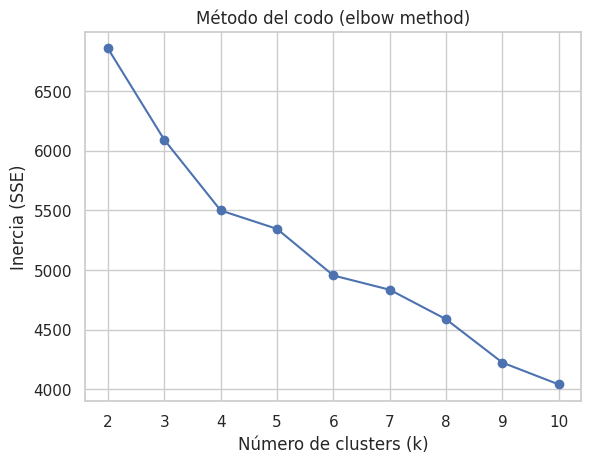

In [ ]:
from sklearn.cluster import KMeans

inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (SSE)')
plt.title('Método del codo (elbow method)')
plt.grid(True)
plt.show()

KMeans clustering is applied **directly** on the original 32-dimensional embedding space. This choice ensures that the grouping of similar holds is based on the learned latent representations, rather than on any transformation introduced by a dimensionality reduction technique.

For visualization purposes only, **t-distributed Stochastic Neighbor Embedding (t-SNE)** is subsequently applied to project the high-dimensional embeddings into a 2D space.

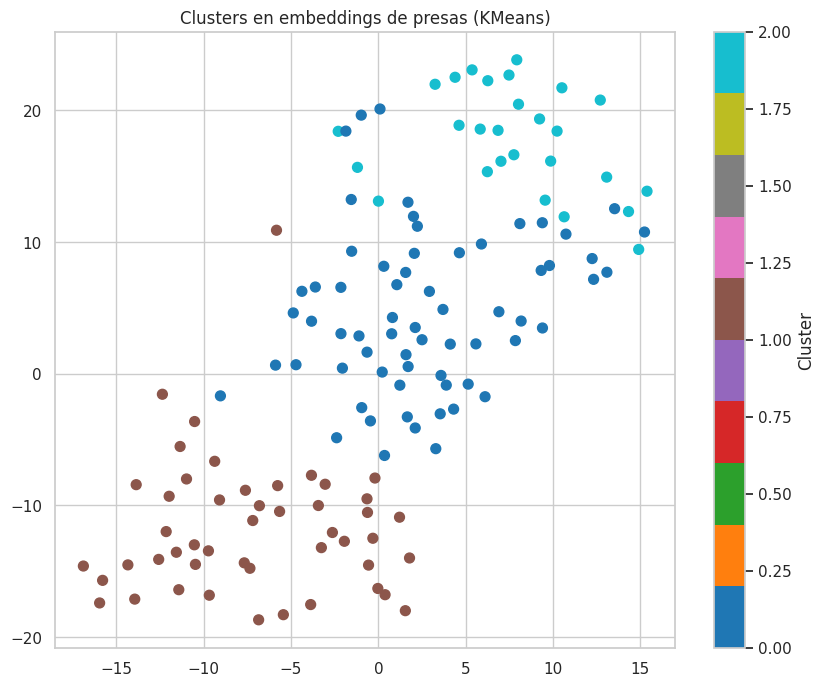

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title("Clusters en embeddings de presas (KMeans)")
plt.grid(True)
plt.show()

## Cluster Visualization of Hold Images

This code will display a random selection of hold images grouped by their assigned cluster. Each row corresponds to a different cluster, and each image represents a hold that was assigned to that cluster.

The goal of this visualization is to provide an intuitive sense of the **visual coherence** within each cluster. If the clustering has captured meaningful visual patterns, holds within the same row should appear similar in terms of shape, texture, or other visual features.

Some key observations to consider while interpreting the plot:

- Clusters with consistent visual properties (e.g., all crimps or all pockets) suggest that the embedding space reflects hold semantics.
- Rows with high visual diversity may indicate overlapping clusters or weak separation.
- Missing images are indicated with a placeholder and may reflect holds that were not correctly processed or segmented.

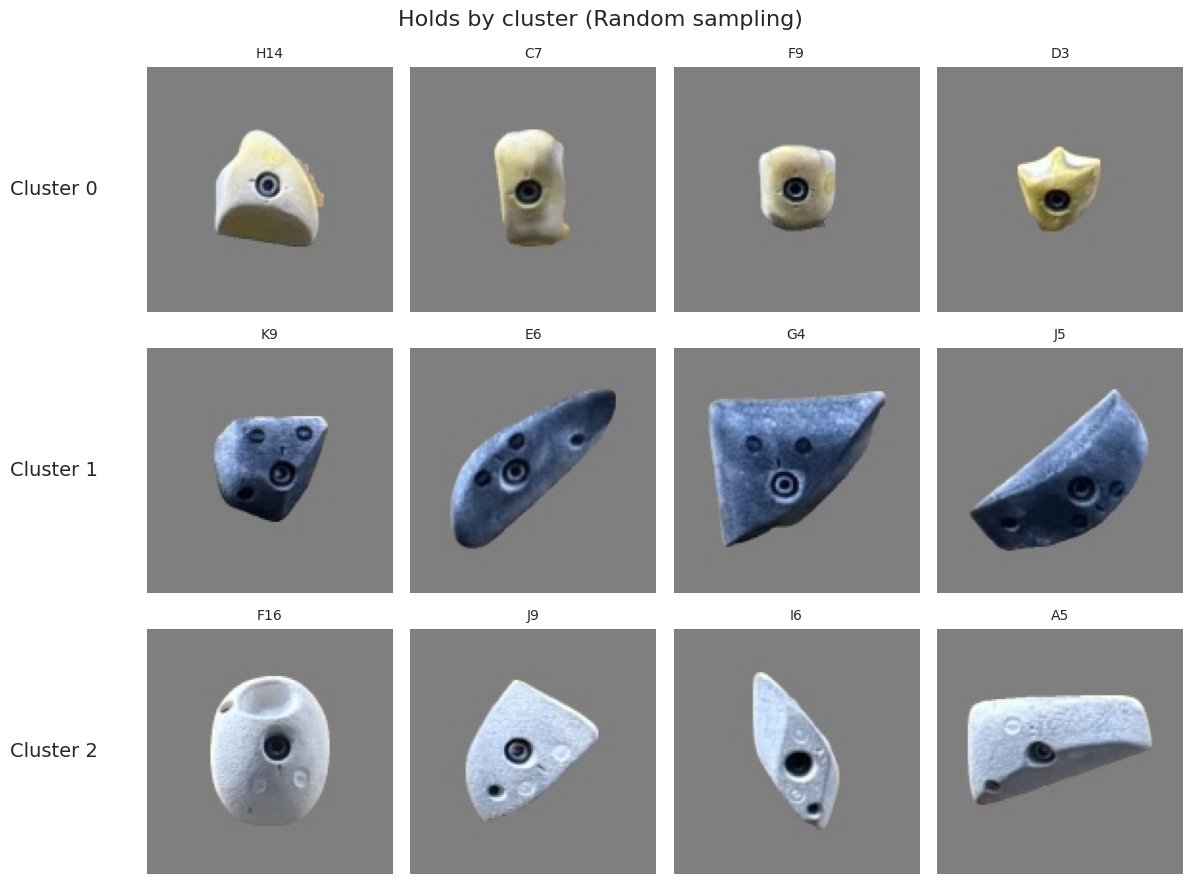

In [ ]:
import random

image_folder = "holds"
num_clusters = len(set(labels))
samples_per_cluster = 4

# Hold names by cluster
holds_by_cluster = {k: [] for k in range(num_clusters)}

for idx, name in idx_to_hold.items():
    if idx < len(labels):
        cluster_id = labels[idx]
        holds_by_cluster[cluster_id].append(name)

# Display one row per cluster
fig, axs = plt.subplots(num_clusters, samples_per_cluster, figsize=(samples_per_cluster * 3, num_clusters * 3))

if num_clusters == 1:
    axs = [axs]  # Ensure axs is iterable when there is only one cluster

for cluster_id in range(num_clusters):
    holds = holds_by_cluster[cluster_id]
    random.shuffle(holds)  # Randomly shuffle holds in the cluster
    for i in range(samples_per_cluster):
        ax = axs[cluster_id][i] if num_clusters > 1 else axs[i]
        if i < len(holds):
            name = holds[i]
            route = os.path.join(image_folder, name + ".jpg")
            if os.path.exists(route):
                img = Image.open(route)
                ax.imshow(img)
                ax.set_title(f"{name}", fontsize=10)
            else:
                ax.text(0.5, 0.5, f"{name}.jpg\nnot found", ha='center', va='center')
        ax.axis("off")
    axs[cluster_id][0].text(-0.2, 0.5, f"Cluster {cluster_id}", fontsize=14, va='center', ha='right', transform=axs[cluster_id][0].transAxes)

plt.suptitle("Holds by cluster (Random sampling)", fontsize=16)
plt.tight_layout()
plt.show()

Clear alignment was observed between the learned clusters and the official MoonBoard hold sets:

![MoonBoard Hold Sets](https://moonclimbing.com/media/catalog/product/cache/d6cc8bf5bd96a83606fc1c516f2f9600/2/0/2016-holdset-bundle.jpg)

- 🟡 **Set A (Yellow)**: Characterized by small, rounded edges and technical shapes. Used mainly for training on small edges. Considered the most "old-school" of the three.
- ⚪ **Set B (White)**: Holds with more diverse shapes (slopers, pinches, edges). Offers greater grip variety and is more versatile than Set A.
- ⚫ **Set C (Black)**: Includes larger, ergonomic holds with positive grips. Designed for dynamic or powerful moves and suited for climbers of all levels.

This suggests that the clustering captured not only visual features but also high-level semantic patterns like hold shape, size, and even color.

*Image and hold descriptions taken from the official MoonBoard website: [moonclimbing.com](https://moonclimbing.com/moonboard/holds-and-bolts/moonboard-2016-setup-hold-bundle.html).*



# Second approach: Spatial relationships + Hold semantic features

## Creating the new enriched input

In [ ]:
#from 18x11 to 18x11xc
def matrix_to_tensor(bin_matrix, hold_to_idx, embeddings, embedding_dim=32):
    tensor = np.zeros((18, 11, embedding_dim), dtype=np.float32)

    for i in range(18):
        for j in range(11):
            if bin_matrix[i][j] == 1:
                hold_name = idx_to_hold(i, j)
                if hold_name in hold_to_idx:
                    idx = hold_to_idx[hold_name]
                    tensor[i, j] = embeddings[idx]
                else:
                    print(f"[Warning] {hold_name} does not have embedding")
    return tensor

In [ ]:
# The transformation is applied and a new column is created with this information
df["tensor"] = df["matrix"].apply(lambda m: matrix_to_tensor(m, hold_to_idx, embeddings))

In [ ]:
df["tensor"][1].shape

(18, 11, 32)

The new model is now ready to be fed with this enriched representation of the MoonBoard routes.

## Splitting the data

In [ ]:
# Filter Benchmarks as test group
df_test = df[df['benchmark'] == True]
df_train_val = df[df['benchmark'] == False]

X_train = np.stack(df_train_val['tensor'].to_numpy())
X_test = np.stack(df_test['tensor'].to_numpy())

## Training

In [ ]:
tensorcnn = tf.keras.models.Sequential([
    layers.Input(shape=(18, 11, 32)),  # New input
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')
])

tensorlstm = tf.keras.models.Sequential([
    layers.Input(shape=(18, 11, 32)), # New input
    layers.Reshape((18, 11 * 32)),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

In [ ]:
models = [ tensorcnn, tensorlstm ]

for model in models:
    model.compile(
        loss = 'mean_squared_error',
        optimizer = 'adam',
        metrics = [
            tf.keras.metrics.RootMeanSquaredError( name = 'RMSE' ),
            tf.keras.metrics.MeanAbsoluteError( name = 'MAE' ),
        ]
    )

### Convolusional neural network

In [ ]:
print("\nTraining model: tensor 2DCNN")
start_time = time.time()

history = tensorcnn.fit(
    X_train,
    y_train_scaled,
    validation_data=(X_test, y_test_scaled),
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            start_from_epoch=10,
        )
    ],
    verbose=1
)

# Training time
fit_time = time.time() - start_time
print(f"🕒 Time to Fit 2DCNN: {fit_time:.2f} seconds")


Training model: tensor 2DCNN
Epoch 1/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - MAE: 0.1736 - RMSE: 0.2716 - loss: 0.0931 - val_MAE: 0.1381 - val_RMSE: 0.1713 - val_loss: 0.0293
Epoch 2/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - MAE: 0.1284 - RMSE: 0.1700 - loss: 0.0289 - val_MAE: 0.1354 - val_RMSE: 0.1680 - val_loss: 0.0282
Epoch 3/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - MAE: 0.1202 - RMSE: 0.1601 - loss: 0.0256 - val_MAE: 0.1195 - val_RMSE: 0.1508 - val_loss: 0.0227
Epoch 4/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - MAE: 0.1160 - RMSE: 0.1555 - loss: 0.0242 - val_MAE: 0.1215 - val_RMSE: 0.1541 - val_loss: 0.0238
Epoch 5/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - MAE: 0.1133 - RMSE: 0.1520 - loss: 0.0231 - val_MAE: 0.1202 - val_RMSE: 0.1508 - val_loss: 0.0227
Epoch 6/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - MAE: 0.1105 - RMSE: 0.1485 - loss: 0.0220 - val_MAE: 0.1468 - val_RMSE: 0.1834 - val_loss: 0.0336
Epoch 7/50
8352/8352 ━━━━━━━━━━━━━━━━━━━

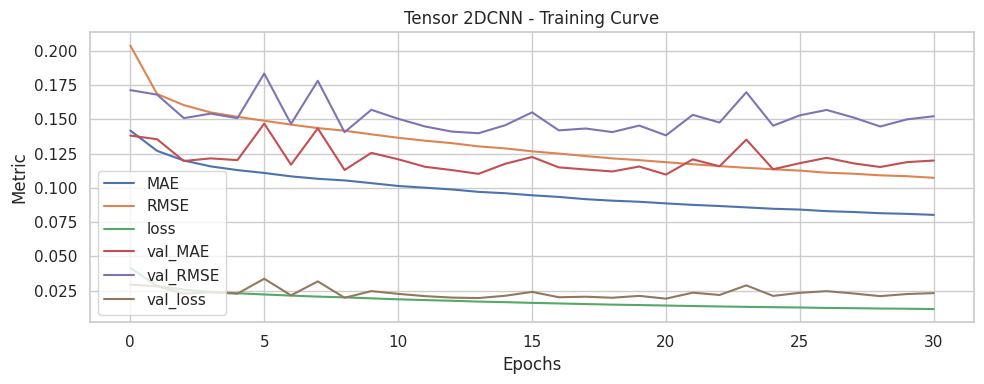

In [ ]:
# Training curves
plt.figure(figsize=(10, 4))
for key in history.history.keys():
    plt.plot(history.history[key], label=key)
plt.title('Tensor 2DCNN - Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The training curves of the 2DCNN model indicate a generally stable and effective learning process. The training metrics (MAE, RMSE, and loss) were observed to decrease steadily, suggesting that the model was successfully minimizing the error on the training set.

The validation metrics remained consistently low throughout the training, which suggests that the model was able to generalize reasonably well. However, some fluctuations were noticed in the validation MAE and RMSE, which may indicate sensitivity to certain examples in the validation set. This noise could be attributed to factors such as limited validation data or high variability in the problem distribution.

### LSTM

In [ ]:
print("\nTraining model: tensor LSTM")
start_time = time.time()

history = tensorlstm.fit(
    X_train,
    y_train_scaled,
    validation_data=(X_test, y_test_scaled),
    epochs=50,
    batch_size=8,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=10,
            restore_best_weights=True,
            start_from_epoch=10,
        )
    ],
    verbose=1
)

# Training time
fit_time = time.time() - start_time
print(f"🕒 Time to Fit 2DCNN: {fit_time:.2f} seconds")


Training model: tensor LSTM
Epoch 1/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - MAE: 0.1366 - RMSE: 0.1844 - loss: 0.0344 - val_MAE: 0.1285 - val_RMSE: 0.1590 - val_loss: 0.0253
Epoch 2/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - MAE: 0.1123 - RMSE: 0.1527 - loss: 0.0233 - val_MAE: 0.1399 - val_RMSE: 0.1737 - val_loss: 0.0302
Epoch 3/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - MAE: 0.1076 - RMSE: 0.1462 - loss: 0.0214 - val_MAE: 0.1337 - val_RMSE: 0.1652 - val_loss: 0.0273
Epoch 4/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - MAE: 0.1036 - RMSE: 0.1405 - loss: 0.0198 - val_MAE: 0.1208 - val_RMSE: 0.1529 - val_loss: 0.0234
Epoch 5/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - MAE: 0.0984 - RMSE: 0.1338 - loss: 0.0179 - val_MAE: 0.1207 - val_RMSE: 0.1515 - val_loss: 0.0230
Epoch 6/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - MAE: 0.0946 - RMSE: 0.1285 - loss: 0.0165 - val_MAE: 0.1219 - val_RMSE: 0.1536 - val_loss: 0.0236
Epoch 7/50
8352/8352 ━━━━━━━━━━━━━━━━━━━━

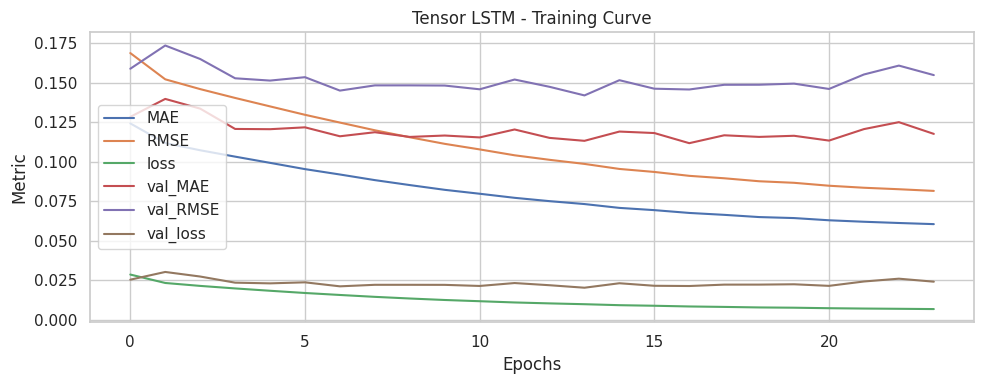

In [ ]:
# Training curves
plt.figure(figsize=(10, 4))
for key in history.history.keys():
    plt.plot(history.history[key], label=key)
plt.title('Tensor LSTM - Training Curve')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The training curves of the LSTM model show that all training metrics (MAE, RMSE, and loss) were steadily reduced over time, indicating that the model successfully learned from the training data.

The validation metrics remained relatively stable across epochs, without showing significant improvement. The validation MAE and RMSE metrics fluctuated slightly and plateaued early in training, suggesting that the model’s ability to generalize was limited.

Compared to the training metrics, a more noticeable performance gap was observed, which may point to overfitting. Despite the decreasing training loss, no corresponding improvement in validation performance was seen after the initial few epochs.

Overall, the LSTM model was able to learn the training data well, but its generalization capability appeared more constrained compared to the CNN. The use of regularization techniques or more expressive input representations may help address this limitation in future work.

## Evaluation

In [ ]:
#2DCNN
pred_scaled_cnn = tensorcnn.predict(X_test)
pred_cnn = scaler.inverse_transform(pred_scaled_cnn).flatten()

mae_value_cnn = mae(y_test, pred_cnn)
rmse_value_cnn = mse(y_test, pred_cnn)

#LSTM
pred_scaled_lstm = tensorlstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_scaled_lstm).flatten()

mae_value_lstm = mae(y_test, pred_lstm)
rmse_value_lstm = mse(y_test, pred_lstm)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
print("Convolusional neural network")
print(f"CNN Test MAE: {mae_value_cnn:.3f}")
print(f"CNN Test RMSE: {rmse_value_cnn:.3f}")
print("---")

print("Long Short Term Memory")
print(f"LSTM Test MAE: {mae_value_lstm:.3f}")
print(f"LSTM Test RMSE: {rmse_value_lstm:.3f}")

Convolusional neural network
CNN Test MAE: 0.877
CNN Test RMSE: 1.223
---
Long Short Term Memory
LSTM Test MAE: 0.906
LSTM Test RMSE: 1.292


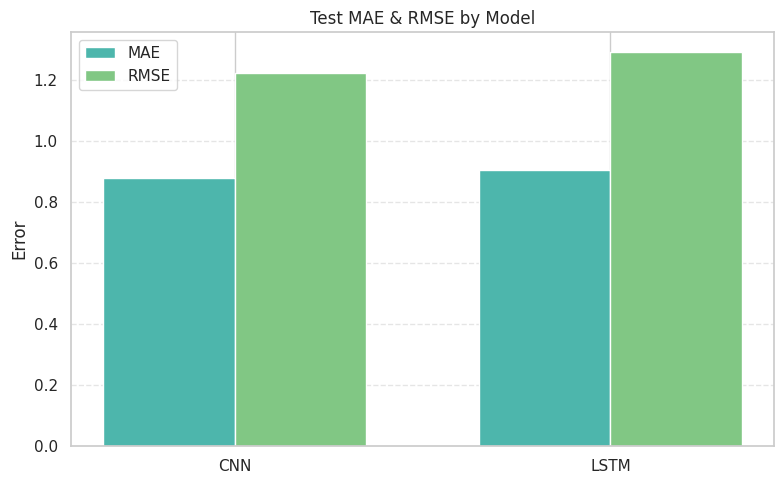

In [ ]:
# Metrics
models = ['CNN', 'LSTM']
mae_scores = [mae_value_cnn, mae_value_lstm]
rmse_scores = [rmse_value_cnn, rmse_value_lstm]

x = range(len(models))
width = 0.35

plt.figure(figsize=(8, 5))

mae_color = '#4DB6AC'
rmse_color = '#81C784'

# Bars
plt.bar([i - width/2 for i in x], mae_scores, width=width, label='MAE', color=mae_color)
plt.bar([i + width/2 for i in x], rmse_scores, width=width, label='RMSE', color=rmse_color)

plt.xticks(x, models)
plt.ylabel("Error")
plt.title("Test MAE & RMSE by Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

- The results indicate that the Convolutional Neural Network (CNN) outperformed the Long Short-Term Memory (LSTM) model in terms of both MAE and RMSE. Specifically, the CNN achieved a lower test MAE of 0.877 and a test RMSE of 1.223, compared to the LSTM's MAE of 0.906 and RMSE of 1.292.

- These findings suggest that, under the current experimental setup, CNNs were better suited to capturing the semantic richness encoded in the hold embeddings. The superior performance of CNNs may be attributed to their ability to effectively leverage visual features learned from the autoencoder, allowing them to extract more meaningful information from the input representation.


A comparison was conducted between two modeling approaches: one using only the spatial configuration of holds, and another incorporating enriched representations that combine spatial and visual semantic embeddings.


| Model | Representation Type              | Test MAE | Test RMSE |
|-------|----------------------------------|----------|-----------|
| CNN   | Spatial Only                     | 0.951    | 1.418     |
| LSTM  | Spatial Only                     | 0.929    | 1.354     |
| CNN   | Enriched (Spatial + Embedding)   | **0.877** | **1.223** |
| LSTM  | Enriched (Spatial + Embedding)   | **0.906** | **1.292** |


These results indicate that models using enriched representations consistently outperformed their spatial-only counterparts in both MAE and RMSE. The improvements suggest that the inclusion of semantic visual features—learned via embeddings—provides valuable additional information that enhances the model's ability to predict difficulty grades. Notably, the CNN model benefited the most from this enrichment, reinforcing its capacity to exploit structured visual information.

# Conclusions

- Through the integration of visual semantics into MoonBoard route representations, a measurable improvement in prediction accuracy was achieved. This finding supports the hypothesis that hold appearance contributes meaningfully to perceived difficulty. By leveraging convolutional autoencoders to encode these features, a richer input space was constructed without manual annotation.

- Although further improvements could be attained by incorporating additional contextual data (e.g., wall angle, movement direction, or climber characteristics), this study demonstrates a promising step toward more climber-aware and visually grounded route modeling. Future work may explore more advanced architectures such as transformers or graph neural networks.